In [118]:
import pandas as pd
import numpy as np
from pandas_datareader import DataReader as pdr
from pandas_datareader.famafrench import get_available_datasets as ffdata
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from datetime import datetime

# connect to SQL database

ODBC = True

from sqlalchemy import create_engine
server = 'fs.rice.edu'
database = 'stocks'
username = 'stocks'
password = '6LAZH1'
if ODBC :
    driver = 'SQL+Server'
    # driver = 'ODBC+Driver+17+for+SQL+Server' # use for linux
    string = "mssql+pyodbc://" + username + ":" + password + "@" + server + "/" + database + "?driver=" + driver
    conn = create_engine(string).connect()
else :
    import pymssql
    string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database 
    conn = create_engine(string).connect()
    
# transaction data

df = pd.read_csv('TransactionHistory_1_20_2022.csv',parse_dates=['CreateDate'])
df = df.drop(columns=['CompanyName','Exchange','FXRate','Currency','SecurityType'])
df['Price'] = df.Price.apply(lambda x: x[1:]).astype(float)
df['Quantity'] = df.Quantity.astype(int)
df = df.sort_values(by=['Symbol','CreateDate','TransactionType'])
df = df.drop_duplicates(subset=['Symbol','Quantity','Price','CreateDate'],keep='first')

# cashflow and cash by date

df['cashflow'] = np.where(df.TransactionType=='Dividends',df.Quantity*df.Price,-df.Quantity*df.Price)
cashFlow = df.copy()
cashFlow['CreateDate'] = pd.to_datetime(cashFlow.CreateDate.dt.date)
cashFlow = cashFlow.groupby('CreateDate').cashflow.sum().sort_index()
dcashFlow.index.name = 'date'
cash = cashFlow.cumsum() + 1000000
cash.name = 'cash'

# now drop dividend rows from df
df = df[df.TransactionType != 'Dividends']

# now compute net quantities
df['NetQuantity'] = 

# database indexed by ticker with start date, end date, and quantity

starts = df.groupby('Symbol').CreateDate.min()
ends = df.groupby('Symbol').CreateDate.max()
quantities = df.groupby('Symbol').Quantity.apply(lambda x: x.iloc[0])
stocks = pd.concat((starts,ends,quantities),axis=1)
stocks.columns = ['start','end','quantity']
for tick in stocks.index :
    stocks.loc[tick,'end'] = datetime.now() if stocks.loc[tick,'end']==stocks.loc[tick,'start'] \
                else stocks.loc[tick,'end']
stocks['start'] = pd.to_datetime(stocks.start.dt.date)
stocks['end'] = pd.to_datetime(stocks.end.dt.date)

# all dates between start and end with ticker and quantity

history = None
for tick in stocks.index :
    d = pd.date_range(stocks.loc[tick,'start'],stocks.loc[tick,'end'])
    d = pd.DataFrame(d)
    d.columns = ['date']
    d['ticker'] = tick
    d['quantity'] = stocks.loc[tick,'quantity']
    history = pd.concat((history,d)) 
    
# SQL data

daily = pd.read_sql(" select a.ticker, date, close_ as price, ret, famaindustry as industry " 
                    " from MarketDaily a inner join Companies b on a.ticker=b.ticker " 
                    " where date>='2021-11-01' "
                    " order by ticker, date ", conn)
daily['date'] = pd.to_datetime(daily.date)

# all trading days and tickers in the portfolio with price, quantity, etc.

history = daily.merge(history,on=['ticker','date'],how='left')
history = history.dropna(subset=['quantity'])
history['value'] = history.price*history.quantity
history['sign'] = np.where(history.quantity>0,'long','short')
history['gain'] = history.groupby('ticker').value.diff()

# gains on longs and shorts and on Russell 2000 for all trading days

gains = history.groupby(['date','sign']).gain.sum().unstack()
russell = pdr('IWM','yahoo',start='2021-11-04')
gains['russell'] = 1000000*russell.Close.diff() / russell.Close.iloc[0]

# portfolio value including cash

portfolio = history.groupby(['date','sign']).value.sum().unstack()
portfolio = pd.concat((portfolio,cash),axis=1)
portfolio['cash'] = portfolio.cash.ffill()

# total portfolio value by date

total = portfolio.sum(axis=1)

# industry gains

industries = history.groupby(['industry','sign']).gain.sum().unstack()

In [ ]:
df['CreateDate'] = pd.to_datetime(df.CreateDate.dt.date)

In [126]:
df = pd.read_csv('TransactionHistory_1_20_2022.csv',parse_dates=['CreateDate'])
df = df.drop(columns=['CompanyName','Exchange','FXRate','Currency','SecurityType'])
df['Price'] = df.Price.apply(lambda x: x[1:]).astype(float)
df['Quantity'] = df.Quantity.astype(int)
df = df.sort_values(by=['Symbol','CreateDate','TransactionType'])
df = df.drop_duplicates(subset=['Symbol','Quantity','Price','CreateDate'],keep='first')

In [127]:
df['TotalQuantity'] = df.groupby('Symbol').Quantity.cumsum()

In [128]:
df.head(10)

,Symbol,TransactionType,Quantity,Price,CreateDate,TotalQuantity
104,ACCD,Short Proceeds,-899,26.09,2021-12-23 14:46:00,-899
4,ACCD,Market - Cover,899,19.45,2022-01-14 14:47:00,0
354,ADS,Market - Buy,231,87.10,2021-11-04 15:44:00,231
256,ADS,Dividends,231,0.21,2021-11-10 00:00:00,462
144,ADS,Market - Sell,-231,67.23,2021-12-17 14:29:00,231
286,ADUS,Short Proceeds,-198,101.30,2021-11-05 09:31:00,-198
167,ADUS,Market - Cover,198,92.23,2021-12-10 13:52:00,0
223,AEYE,Short Proceeds,-2607,8.28,2021-11-19 10:10:00,-2607
92,AI,Short Proceeds,-645,32.82,2021-12-30 14:49:00,-645
24,AI,Short Proceeds,-802,27.77,2022-01-14 13:57:00,-1447


In [122]:
counts = df.groupby('Symbol').Quantity.count()
ticks = counts[counts>2].index
df[df.Symbol.isin(ticks)]

,Symbol,TransactionType,Quantity,Price,CreateDate,cashflow
132,CMMB,Market - Buy,1464,6.90,2021-12-17,-10101.60
125,CMMB,Market - Sell,-1464,7.35,2021-12-23,10760.40
22,CMMB,Short Proceeds,-3636,6.55,2022-01-14,23815.80
164,EOSE,Short Proceeds,-2677,8.02,2021-12-10,21469.54
129,EOSE,Short Proceeds,-540,7.98,2021-12-17,4309.20
5,EOSE,Short Proceeds,-2600,5.62,2022-01-14,14612.00
36,EOSE,Short Proceeds,-110,5.53,2022-01-14,608.30
106,HSDT,Short Proceeds,-3944,5.60,2021-12-23,22086.40
26,HSDT,Short Proceeds,3940,5.17,2022-01-14,-20369.80
27,HSDT,Short Proceeds,-4830,5.07,2022-01-14,24488.10


In [124]:
df[df.Symbol=='NTRB']

,Symbol,TransactionType,Quantity,Price,CreateDate
195,NTRB,Short Proceeds,-3332,6.37,2021-11-26
9,NTRB,Market - Cover,3332,6.21,2022-01-14
8,NTRB,Short Proceeds,3332,6.21,2022-01-14


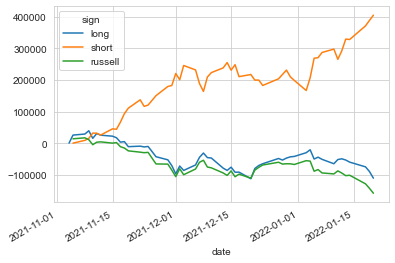

In [119]:
gains.cumsum().plot()
plt.savefig('CQA.pdf')

<AxesSubplot:xlabel='date'>

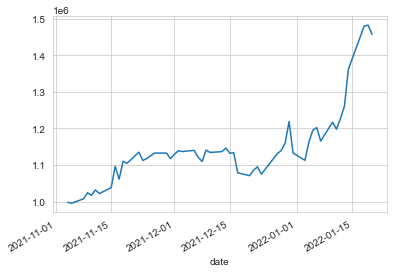

In [120]:
total.plot()

In [100]:
history.head()

,ticker,date,price,ret,industry,quantity,value,sign,gain
2617,ACCD,2021-12-23,26.31,0.048625,Business Services,-899.0,-23652.69,short,NaN
2618,ACCD,2021-12-27,26.31,0.000000,Business Services,-899.0,-23652.69,short,0.00
2619,ACCD,2021-12-28,25.94,-0.014063,Business Services,-899.0,-23320.06,short,332.63
2620,ACCD,2021-12-29,25.80,-0.005397,Business Services,-899.0,-23194.20,short,125.86
2621,ACCD,2021-12-30,26.27,0.018217,Business Services,-899.0,-23616.73,short,-422.53


In [101]:
gains.head()

sign,long,short,russell
date,,,
2021-11-04,0.00,NaN,NaN
2021-11-05,25460.66,0.00,13665.874932
2021-11-08,3291.93,8746.98,3143.994929
2021-11-09,10360.08,6198.46,-5910.725819
2021-11-10,-23905.12,16858.92,-15929.523137


In [105]:
portfolio.head()

,long,short,cash
date,,,
2021-11-04,718464.68,NaN,279416.27
2021-11-05,980003.33,-999653.20,1015123.83
2021-11-08,983295.26,-990906.22,1015176.33
2021-11-09,993655.34,-984707.76,1015176.33
2021-11-10,969750.22,-967848.84,1015179.85


In [103]:
total.head()

date
2021-11-04     997880.95
2021-11-05     995473.96
2021-11-08    1007565.37
2021-11-09    1024123.91
2021-11-10    1017081.23
dtype: float64

In [104]:
industries

sign,long,short
industry,,
Agriculture,NaN,655.52
Aircraft,-3537.800,NaN
Automobiles and Trucks,3338.360,16051.90
Banking,-11599.430,2861.22
Business Services,-14928.840,43912.82
Business Supplies,7921.200,NaN
Candy & Soda,-1502.460,NaN
Chemicals,-87.560,7458.00
Coal,11269.410,NaN


In [106]:
df.head()

,Symbol,TransactionType,Quantity,Price,CreateDate,cash
104,ACCD,Short Proceeds,-899,26.09,2021-12-23,23454.91
4,ACCD,Market - Cover,899,19.45,2022-01-14,-17485.55
354,ADS,Market - Buy,231,87.10,2021-11-04,-20120.10
144,ADS,Market - Sell,-231,67.23,2021-12-17,15530.13
286,ADUS,Short Proceeds,-198,101.30,2021-11-05,20057.40


In [107]:
opens = pd.read_csv('OpenPosition_1_20_2022.csv')
opens1 = opens.Symbol.unique()
counts = df.groupby('Symbol').CreateDate.count()
opens2 = counts[counts==1].index.to_list()
opens3 = history[history.date==history.date.max()].ticker.unique()
print(len(opens1))
print(len(opens2))
print(len(opens3))

105
101
98


In [108]:
longs1 = opens[opens.Quantity>0].Symbol.to_list()
shorts1 = opens[opens.Quantity<0].Symbol.to_list()

In [109]:
longs3 = history[(history.date==history.date.max()) & (history.quantity>0)].ticker.unique()
shorts3 = history[(history.date==history.date.max()) & (history.quantity<0)].ticker.unique()

In [110]:
opens4 = stocks[stocks.end==stocks.end.max()]
longs4 = opens4[opens4.quantity>0].index.to_list()
shorts4 = opens4[opens4.quantity<0].index.to_list()

In [111]:
print(len(longs1))
print(len(longs3))
print(len(longs4),'\n')
print(len(shorts1))
print(len(shorts3))
print(len(shorts4))

50
45
48 

55
53
53


In [112]:
missing_longs = [x for x in longs1 if x not in longs4]
df[df.Symbol.isin(missing_longs)]

,Symbol,TransactionType,Quantity,Price,CreateDate,cash


In [113]:
missing_shorts = [x for x in shorts1 if x not in shorts4]
df[df.Symbol.isin(missing_shorts)]

,Symbol,TransactionType,Quantity,Price,CreateDate,cash
132,CMMB,Market - Buy,1464,6.90,2021-12-17,-10101.60
125,CMMB,Market - Sell,-1464,7.35,2021-12-23,10760.40
22,CMMB,Short Proceeds,-3636,6.55,2022-01-14,23815.80
195,NTRB,Short Proceeds,-3332,6.37,2021-11-26,21224.84
9,NTRB,Market - Cover,3332,6.21,2022-01-14,-20691.72
331,SPCE,Market - Buy,1014,19.63,2021-11-04,-19904.82
250,SPCE,Market - Sell,-1014,18.82,2021-11-16,19083.48
64,SPCE,Short Proceeds,-1799,12.68,2022-01-07,22811.32
